# Branch Classifier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import cProfile
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pstats
import sys
import tifffile as tf
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("../")
from data_prep import collect, load, draw, save, image
from data_prep.image import Image
from solvers import branch_classifier
import models
DATE = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [11]:
seeds = glob(os.path.join('/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts/8-STRESS_2w_Female_HIP_7', '*seeds.txt'))[0]
# Load seeds from text file into a list of integers
with open(seeds, 'r') as f:
    seed_list = [[int(x) for x in line.strip().split(' ')] for line in f if line.strip()]
    
print(f"Loaded {len(seed_list)} seeds")
print(f"{seed_list}")

Loaded 1 seeds
[[18, 248, 343]]


In [ ]:
import json

section_graph = glob(os.path.join('/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts/8-STRESS_2w_Female_HIP_7', '*section_graph.json'))[0]
with open(section_graph, 'r') as f:
    section_graph = json.load(f)
    # Convert all keys from string to int
    section_graph = {int(k): v for k, v in section_graph.items()}

In [16]:
section_graph

{'2': [3, 5, 10, 26, 35, 12, 68, 37, 51],
 '3': [2, 5, 10, 26, 35, 12, 68, 37, 51],
 '5': [2, 3, 10, 26, 35, 12, 68, 37, 51],
 '10': [2, 3, 5, 26, 35, 12, 68, 37, 51],
 '15': [22],
 '22': [15],
 '26': [2, 3, 5, 10, 35, 12, 68, 37, 51],
 '35': [2, 3, 5, 10, 26, 12, 68, 37, 51],
 '42': [43],
 '46': [48],
 '48': [46],
 '55': [60],
 '60': [55],
 '65': [66],
 '66': [65],
 '70': [74],
 '74': [70],
 '12': [2, 3, 5, 10, 26, 35, 68, 37, 51],
 '43': [42],
 '53': [61],
 '61': [53],
 '68': [2, 3, 5, 10, 26, 35, 12, 37, 51],
 '37': [2, 3, 5, 10, 26, 35, 12, 68, 51],
 '51': [2, 3, 5, 10, 26, 35, 12, 68, 37]}

## Collect branch classifier training data
Training data consists of volumetric image patches chosen randomly from the neuron node coordinates given\
in the SWC file with an added small random translation. Image patches are labeled 1 if they are centered on\
 a branch point and 0 otherwise.

### Get sample points from swc files then save sample spherical patches

In [3]:
# Load SWC file data into python lists
# swc_dir = "/nafs/dtward/bryson/gold166_swc_scaled"
# swc_files = os.listdir(swc_dir)
swc_dir = "/nafs/dtward/bryson/data/neuromorpho"
swc_files = [f for x in os.walk(swc_dir) for f in glob(os.path.join(x[0], '*.swc'))]
swc_files = sorted(swc_files)

# img_dir = "/nafs/dtward/bryson/gold166_tifs_scaled/"
# img_files = os.listdir(img_dir)
img_dir = "/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts"
img_files = [f for x in os.walk(img_dir) for f in glob(os.path.join(x[0], '*image.tif'))]
img_files = sorted(img_files)

section_labels_files = [f for x in os.walk(img_dir) for f in glob(os.path.join(x[0], '*sections.tif'))]
section_labels_files = sorted(section_labels_files)

density_files = [f for x in os.walk(img_dir) for f in glob(os.path.join(x[0], '*density.tif'))]
density_files = sorted(density_files)

branch_mask_files = [f for x in os.walk(img_dir) for f in glob(os.path.join(x[0], '*branches.tif'))]
branch_mask_files = sorted(branch_mask_files)

# out_dir = os.path.expanduser("~/bmap/gold166_classifier_data/")
out_dir = os.path.expanduser("~/bmap/data/simulated_neurons/neuromorpho_branch_classifier_with_artifacts")

if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
    print(f"Created directory: {out_dir}")
if not os.path.exists(os.path.join(out_dir, "observations")):
    os.makedirs(os.path.join(out_dir, "observations"))


## Test branch extraction methods

## Acquire large square patches for on-the-fly patch extraction

In [5]:
# Specify one image
# img_file = img_files[4]
swc_file = swc_files[4]
img_file = [f for f in img_files if f.split('/')[-1].split('_image')[0] == swc_file.split('/')[-1].split('.')[0]][0]
img = tf.imread(img_file)
# get its branches
# swc_file = [f for f in swc_files if f.split('/')[-1].split('.')[0] == img_file.split('/')[-1].split('_image')[0]][0]
swc_list = load.swc(swc_file)
sections, section_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)#, length_threshold=4.0)
sections, branches, terminals, scale = load.adjust_neuron_coords(sections, branches, terminals)

loading file: /nafs/dtward/bryson/data/neuromorpho/borst/CNG version/dHSN_02l.CNG.swc
removing 21 branches


In [6]:
shape = img.shape[1:]
branch_mask = Image(torch.zeros((1,)+shape, dtype=torch.bool))
for point in branches:
    # r = point[3].item() #/ xy_scale
    branch_mask.draw_point(point[:3], radius=3, binary=True, value=1, channel=0)

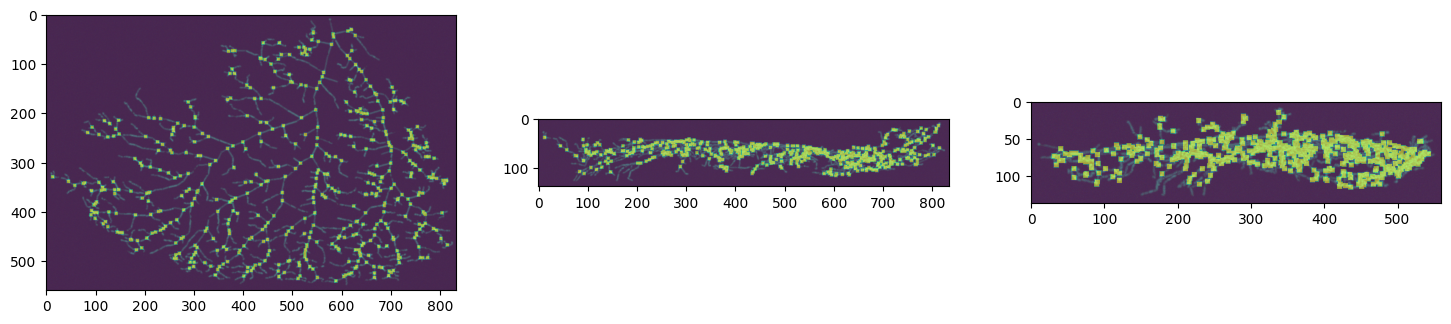

In [7]:
# visualize the image with branch mask
fig, ax = plt.subplots(1,3, figsize=(18,18))

ax[0].imshow(img.max(1).transpose(1,2,0))
ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.5)
ax[1].imshow(img.max(2).transpose(1,2,0))
ax[1].imshow(branch_mask.data[0].amax(1), alpha=0.5)
ax[2].imshow(img.max(3).transpose(1,2,0))
ax[2].imshow(branch_mask.data[0].amax(2), alpha=0.5)

In [9]:
# how many total branches are there?
n_branches = 0
for swc_file in swc_files[:11]:
    swc_list = load.swc(swc_file)
    sections, section_graph = load.parse_swc(swc_list)
    branches, terminals = load.get_critical_points(swc_list, sections)
    n_branches += len(branches)
print(f'There are a total of {n_branches*2} branches.')

loading file: /nafs/dtward/bryson/data/neuromorpho/allen cell types/CNG version/646805498_transformed.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/baier/CNG version/150304_2_3_d.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/baier/CNG version/20160916_BGUG_HuC_ltRFP_d7_F13.CNG.swc
removing 3 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/borst/CNG version/dHSN_02l.CNG.swc
removing 21 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/briggs/CNG version/Bub_9-13_c1.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/buskila/CNG version/MC-Aged-Cont-S2.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/buskila/CNG version/MC-Aged-cont-S1.CNG.swc
removing 0 branches
loading file: /nafs/dtward/bryson/data/neuromorpho/buskila/CNG ver

In [30]:

# create annotations
rng = np.random.default_rng(0)
annotations_ = pd.read_csv(os.path.join(out_dir, f"branch_classifier_{'neuromorpho'}_{DATE}_annotations.csv"))
annotations = {}
for i, row in annotations_.iterrows():
    key = row["Unnamed: 0"]
    value = row[1]
    annotations[key] = value

obs_id = 1704
for swc_file in tqdm(swc_files[11:], desc="Processing SWC files"):
    swc_list = load.swc(swc_file)
    sections, section_graph = load.parse_swc(swc_list)
    branches, terminals = load.get_critical_points(swc_list, sections)
    sections, branches, terminals, scale = load.adjust_neuron_coords(sections, branches, terminals)

    img_file = [f for f in img_files if f.split('/')[-1].split('_image')[0] == swc_file.split('/')[-1].split('.')[0]][0]
    img = tf.imread(img_file)
    img = Image(torch.from_numpy(img))

    for branch in branches:
        patch = img.crop(branch[:3], radius=10)[0]
        fname = f'obs_{obs_id}.tif'
        annotations[fname] = 1
        tf.imwrite(os.path.join(out_dir, 'observations', fname), patch.data.numpy(), compression='zlib')
        obs_id += 1

    points = []
    for section_id, section in sections.items():
        points.append(section[:,0,:3])
    points = np.concatenate(points, axis=0)
    i = 0
    while i < len(branches)//2 + len(branches)%2:

        point = rng.choice(points)

        # Check if this point is far enough from any branch point 
        # to avoid selecting branch points or points too close to branches
        is_far_from_branches = True
        distance = np.linalg.norm(branches[:,:3] - point[None])
        distance = distance.min()
        if distance < 7.0:  # Minimum distance from branches
            is_far_from_branches = False
            break
        
        if is_far_from_branches:
            i += 1
            # Crop patch from image at this point
            patch = img.crop(point[:3], radius=10)[0]
            fname = f'obs_{obs_id}.tif'
            annotations[fname] = 0
            tf.imwrite(os.path.join(out_dir, 'observations', fname), patch.data.numpy(), compression='zlib')
            obs_id += 1
        else:
            continue

    # get len(branches)//2 non-neuron points
    section_labels_file = [f for f in section_labels_files if f.split('/')[-1].split('_sections')[0] == swc_file.split('/')[-1].split('.')[0]][0]
    section_labels = tf.imread(section_labels_file)
    section_labels = section_labels[0]
    i = 0
    while i < len(branches)//2:
        # select a random point in the img
        # Get random coordinates within image dimensions

        # Generate random coordinates within image bounds
        z = rng.integers(0, section_labels.shape[0])
        y = rng.integers(0, section_labels.shape[1])
        x = rng.integers(0, section_labels.shape[2])
        
        # Check if this point is outside neuron (section_labels == 0)
        if section_labels[z, y, x] == 0:
            i += 1
            point = np.array([z, y, x])  # Save as [z,y,x,r] format
            
            # Crop patch from image at this point
            patch = img.crop(point[:3], radius=10)[0]
            fname = f'obs_{obs_id}.tif'
            annotations[fname] = 0
            tf.imwrite(os.path.join(out_dir, 'observations', fname), patch.data.numpy(), compression='zlib')
            obs_id += 1
        else:
            continue

name = "neuromorpho"
data_permutation = torch.randperm(len(annotations))
test_idxs = data_permutation[:len(data_permutation)//5].tolist()
training_idxs = data_permutation[len(data_permutation)//5:].tolist()
training_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in training_idxs}
test_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in test_idxs}
# save
df = pd.DataFrame.from_dict(training_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{DATE}_training_labels.csv"))
df = pd.DataFrame.from_dict(test_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{DATE}_test_labels.csv"))


Processing SWC files:   0%|          | 0/64 [00:00<?, ?it/s]

loading file: /nafs/dtward/bryson/data/neuromorpho/campos/CNG version/Astro-1.CNG.swc
removing 1 branches


Processing SWC files:   2%|▏         | 1/64 [00:05<05:44,  5.46s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/castanho_oliveira/CNG version/13_L3_C3_N5.CNG.swc
removing 0 branches


Processing SWC files:   3%|▎         | 2/64 [00:20<11:38, 11.27s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/charlet/CNG version/CeA_Astrocyte_12_003.CNG.swc
removing 0 branches


Processing SWC files:   5%|▍         | 3/64 [00:43<16:34, 16.30s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/charlet/CNG version/CeA_Astrocyte_3_021.CNG.swc
removing 0 branches


Processing SWC files:   6%|▋         | 4/64 [01:04<18:16, 18.28s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/chiang/CNG version/Cha-F-000302.CNG.swc
removing 0 branches


Processing SWC files:   8%|▊         | 5/64 [01:31<21:13, 21.59s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/chiang/CNG version/Cha-F-600090.CNG.swc
removing 0 branches


Processing SWC files:   9%|▉         | 6/64 [01:59<22:44, 23.53s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/defelipe/CNG version/M1KO_15.CNG.swc
removing 0 branches


Processing SWC files:  11%|█         | 7/64 [02:20<21:46, 22.92s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/denizet/CNG version/cort4c4pg1d.CNG.swc
removing 0 branches


Processing SWC files:  12%|█▎        | 8/64 [02:46<22:18, 23.90s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/denk/CNG version/orphan_3807.CNG.swc
removing 0 branches


Processing SWC files:  14%|█▍        | 9/64 [03:13<22:37, 24.69s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/dierssen/CNG version/WT_6mo_3_11.CNG.swc
removing 0 branches


Processing SWC files:  16%|█▌        | 10/64 [03:36<21:45, 24.18s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/diniz/CNG version/C13_1-6_80um_GFAP_Z-fixed0102_08-April16_C47.CNG.swc
removing 0 branches


Processing SWC files:  17%|█▋        | 11/64 [04:00<21:25, 24.26s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/eyewire/CNG version/skel_20220_sorted.CNG.swc
removing 0 branches


Processing SWC files:  19%|█▉        | 12/64 [05:28<37:50, 43.66s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/flyem/CNG version/KC-p-5303804.CNG.swc
removing 2 branches


Processing SWC files:  20%|██        | 13/64 [06:04<35:02, 41.23s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/gaspar/CNG version/1-CTR_2w_Female_Nac_6.CNG.swc
removing 7 branches


Processing SWC files:  22%|██▏       | 14/64 [06:30<30:40, 36.81s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/gaspar/CNG version/12-DEX-STRESS_male_Nac_7.CNG.swc
removing 0 branches


Processing SWC files:  23%|██▎       | 15/64 [06:37<22:34, 27.63s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/gaspar/CNG version/8-STRESS_2w_Female_HIP_7.CNG.swc
removing 0 branches


Processing SWC files:  25%|██▌       | 16/64 [06:57<20:23, 25.48s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/giniger/CNG version/ABL-OE-14--ims.CNG.swc
removing 0 branches


Processing SWC files:  27%|██▋       | 17/64 [07:21<19:38, 25.08s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/guizzetti/CNG version/P3_CV3_79.CNG.swc
removing 0 branches


Processing SWC files:  28%|██▊       | 18/64 [07:42<18:04, 23.58s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/hamad/CNG version/pcs74_8.CNG.swc
removing 0 branches


Processing SWC files:  30%|██▉       | 19/64 [08:03<17:18, 23.08s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_3.CNG.swc
removing 0 branches


Processing SWC files:  31%|███▏      | 20/64 [08:24<16:23, 22.35s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_5.CNG.swc
removing 0 branches


Processing SWC files:  33%|███▎      | 21/64 [08:49<16:39, 23.24s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/hosseini/CNG version/Aged_mice_VAC-PBS10_58-DG-1.CNG.swc
removing 0 branches


Processing SWC files:  34%|███▍      | 22/64 [09:13<16:25, 23.46s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/jacobs/CNG version/194-2-6lw.CNG.swc
removing 0 branches


Processing SWC files:  36%|███▌      | 23/64 [09:42<17:06, 25.04s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/jefferis/CNG version/NNE1L.CNG.swc
removing 0 branches


Processing SWC files:  38%|███▊      | 24/64 [10:06<16:31, 24.79s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/jongbloets/CNG version/14dpi_WT2_S6_2.CNG.swc
removing 1 branches


Processing SWC files:  39%|███▉      | 25/64 [10:23<14:27, 22.25s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/kuddannaya/CNG version/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18.CNG.swc
removing 0 branches


Processing SWC files:  41%|████      | 26/64 [10:42<13:30, 21.33s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/la barbera/CNG version/1-4_14.CNG.swc
removing 0 branches


Processing SWC files:  42%|████▏     | 27/64 [10:58<12:08, 19.68s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/laBarbera_mercuri/CNG Version/1-4_14.CNG.swc
removing 0 branches


Processing SWC files:  44%|████▍     | 28/64 [11:02<09:00, 15.02s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/luikart/CNG version/C29421-A4-60DPI-TDA-I1-CreCell-3.CNG.swc
removing 0 branches


Processing SWC files:  45%|████▌     | 29/64 [11:17<08:44, 14.98s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/macdonald/CNG version/SD3.CNG.swc
removing 0 branches


Processing SWC files:  47%|████▋     | 30/64 [11:34<08:53, 15.69s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc
removing 0 branches


Processing SWC files:  48%|████▊     | 31/64 [11:47<08:05, 14.71s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/nishitoh/CNG version/D2_C_22.CNG.swc
removing 4 branches


Processing SWC files:  50%|█████     | 32/64 [12:02<08:01, 15.06s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/prichard_singer/CNG version/MsJinx16_NoFlicker_1h_IBA1_NFkBinh_17.CNG.swc
removing 0 branches


Processing SWC files:  52%|█████▏    | 33/64 [12:25<08:56, 17.30s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc
removing 0 branches


Processing SWC files:  53%|█████▎    | 34/64 [12:49<09:44, 19.49s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/roysam/CNG version/farsight879.CNG.swc
removing 0 branches


Processing SWC files:  55%|█████▍    | 35/64 [13:11<09:45, 20.18s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/CN_Development_P15_F_Animal01_Trace040.CNG.swc
removing 0 branches


Processing SWC files:  56%|█████▋    | 36/64 [13:30<09:11, 19.69s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/CN_Development_P22_F_Animal03_Trace009.CNG.swc
removing 0 branches


Processing SWC files:  58%|█████▊    | 37/64 [13:50<08:57, 19.91s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/CN_Development_P22_M_Animal03_Trace047.CNG.swc
removing 0 branches


Processing SWC files:  59%|█████▉    | 38/64 [14:13<09:03, 20.89s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/DG_5xFAD_3mpos_F_Animal02_Trace178.CNG.swc
removing 0 branches


Processing SWC files:  61%|██████    | 39/64 [14:31<08:15, 19.83s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/DG_5xFAD_6mpos_M_Animal03_Trace080.CNG.swc
removing 0 branches


Processing SWC files:  62%|██████▎   | 40/64 [14:48<07:33, 18.91s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/DG_Adulthood_Control_F_Animal01_Trace891.CNG.swc
removing 0 branches


Processing SWC files:  64%|██████▍   | 41/64 [15:19<08:41, 22.66s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/DG_CKp25_2w_M_Animal01_Trace048.CNG.swc
removing 0 branches


Processing SWC files:  66%|██████▌   | 42/64 [15:40<08:08, 22.19s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/DG_Development_P22_M_Animal03_Trace060.CNG.swc
removing 0 branches


Processing SWC files:  67%|██████▋   | 43/64 [16:01<07:40, 21.94s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/FC_Adulthood_Control_M_Animal01_Trace036.CNG.swc
removing 0 branches


Processing SWC files:  69%|██████▉   | 44/64 [16:26<07:33, 22.66s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/FC_Development_P15_M_Animal02_Trace109.CNG.swc
removing 0 branches


Processing SWC files:  70%|███████   | 45/64 [16:52<07:32, 23.79s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/FC_Development_P22_F_Animal03_Trace164.CNG.swc
removing 0 branches


Processing SWC files:  72%|███████▏  | 46/64 [17:23<07:47, 25.97s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/OB_Adulthood_Control_F_Animal04_Trace056.CNG.swc
removing 0 branches


Processing SWC files:  73%|███████▎  | 47/64 [17:47<07:07, 25.18s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_5xFAD_3mpos_M_Animal03_Trace037.CNG.swc
removing 0 branches


Processing SWC files:  75%|███████▌  | 48/64 [18:12<06:42, 25.17s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_5xFAD_6mpos_F_Animal03_Trace003.CNG.swc
removing 0 branches


Processing SWC files:  77%|███████▋  | 49/64 [18:36<06:11, 24.79s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_CKp25_1w_M_Animal02_Trace067.CNG.swc
removing 0 branches


Processing SWC files:  78%|███████▊  | 50/64 [18:59<05:41, 24.39s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_CKp25_6w_F_Animal02_Trace063.CNG.swc
removing 0 branches


Processing SWC files:  80%|███████▉  | 51/64 [19:28<05:36, 25.85s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_CKp25_6w_M_Animal04_Trace008.CNG.swc
removing 0 branches


Processing SWC files:  81%|████████▏ | 52/64 [19:56<05:16, 26.36s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/S1_Ovariectomy_Animal01_Trace032.CNG.swc
removing 0 branches


Processing SWC files:  83%|████████▎ | 53/64 [20:28<05:10, 28.19s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/SN_5xFAD_6mpos_M_Animal03_Trace033.CNG.swc
removing 0 branches


Processing SWC files:  84%|████████▍ | 54/64 [20:49<04:20, 26.04s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/SN_Adulthood_Control_M_Animal08_Trace005.CNG.swc
removing 0 branches


Processing SWC files:  86%|████████▌ | 55/64 [21:18<04:01, 26.83s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/CNG version/SN_Ovariectomy_Animal02_Trace052.CNG.swc
removing 0 branches


Processing SWC files:  88%|████████▊ | 56/64 [21:42<03:27, 25.95s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/siegert/Source-Version/OB_Adulthood_Control_F_Animal04_Trace056.swc
removing 0 branches


/home/bgray/neurotrack/notebooks/../data_prep/image.py:194: UserWarning: Center [136.434  84.564 404.52 ] is out of bounds for image shape torch.Size([235, 536, 396]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/bgray/neurotrack/notebooks/../data_prep/image.py:194: UserWarning: Center [134.313  85.32  414.264] is out of bounds for image shape torch.Size([235, 536, 396]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/bgray/neurotrack/notebooks/../data_prep/image.py:194: UserWarning: Center [141.663  55.941 464.951] is out of bounds for image shape torch.Size([235, 536, 396]). Translating to the nearest valid index.
  warnings.warn(f"Center {center} is out of bounds for image shape {shape}. Translating to the nearest valid index.")
/home/bgray/neurotrack

loading file: /nafs/dtward/bryson/data/neuromorpho/steelman/CNG version/gw-4-image-3_22.CNG.swc
removing 0 branches


Processing SWC files:  91%|█████████ | 58/64 [22:08<01:58, 19.76s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/tenner/CNG version/7month-Arctic-C5aR1-KO-11_2.CNG.swc
removing 0 branches


Processing SWC files:  92%|█████████▏| 59/64 [22:21<01:28, 17.72s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/todd/CNG version/C242-01-08-14-B1.CNG.swc
removing 0 branches


Processing SWC files:  94%|█████████▍| 60/64 [22:46<01:19, 19.88s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/tolias/CNG version/L5MC-J130731a.CNG.swc
removing 1 branches


Processing SWC files:  95%|█████████▌| 61/64 [23:38<01:28, 29.58s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/wong/CNG version/L100P-GSK3-Het-9.CNG.swc
removing 0 branches


Processing SWC files:  97%|█████████▋| 62/64 [23:52<00:49, 24.98s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/yayon_soreq/CNG version/Cell_134_MPD_12_FT_10_XYZ_Sorted-swc_N3DFix-swc_4.CNG.swc
removing 0 branches


Processing SWC files:  98%|█████████▊| 63/64 [24:10<00:22, 22.92s/it]

loading file: /nafs/dtward/bryson/data/neuromorpho/yayon_soreq/CNG version/Cell_528_MPD_8_FT_10_XYZ_Sorted-swc_N3DFix-swc_1.CNG.swc
removing 0 branches


Processing SWC files: 100%|██████████| 64/64 [24:25<00:00, 22.90s/it]


In [11]:
df = pd.DataFrame.from_dict(annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{'neuromorpho'}_{DATE}_annotations.csv"))

## Test spherical patch extraction

In [14]:
# Setup

img = img_files[0]
img = tf.imread(os.path.join(img_dir,img))
img = img / img.max()
branch_coords = [np.array([x//2 for x in img.shape])]
permutations = [[0,1,2],
                [0,2,1],
                [1,2,0],
                [1,0,2],
                [2,0,1],
                [2,1,0]]
# Create meshgrid for spherical coordinates
theta_res, phi_res = (180,360)
theta = np.linspace(0, np.pi, theta_res)
phi = np.linspace(0, 2*np.pi, phi_res)
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

# Convert to cartesian coordinates (points on a unit sphere)
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)
z = np.cos(theta_grid)

In [15]:
# Sample branch positive patches
with cProfile.Profile() as pr:
    for i in range(len(branch_coords)):
        spherical_patches = []
        for r in range(3,55,3):
            for perm in permutations:
                patch = image.extract_spherical_patch(img, x, y, z, branch_coords[i], radius=r, permutation=perm)
                spherical_patches.append(patch)
        patch = np.stack(spherical_patches, axis=0)
    stats = pstats.Stats(pr)
    stats.sort_stats('cumulative').print_stats()
    stats.print_stats()

         5099 function calls (5098 primitive calls) in 0.574 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      108    0.026    0.000    0.562    0.005 /home/bgray/neurotrack/notebooks/../data_prep/image.py:74(extract_spherical_patch)
      108    0.001    0.000    0.503    0.005 /home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/scipy/ndimage/_interpolation.py:358(map_coordinates)
      108    0.497    0.005    0.497    0.005 {built-in method scipy.ndimage._nd_image.geometric_transform}
      108    0.032    0.000    0.032    0.000 {built-in method numpy.array}
  326/325    0.012    0.000    0.013    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.012    0.012 <__array_function__ internals>:2(stack)
        1    0.000    0.000    0.012    0.012 /home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/numpy/core/shape_base.py:357(sta

## Collect branch patch data

## save coordinates and annotations

In [25]:
collect.save_coordinates_and_annotations(swc_dir, img_dir, out_dir, samples_per_neuron=100, seed=0, branch_radius_filter=15.0)

  1%|          | 1/132 [03:16<7:09:07, 196.55s/it]


KeyboardInterrupt: 

In [8]:
# visually check sample of branch points
sample_points_path = "/nafs/dtward/bryson/gold166_classifier_data/sample_points_03-26-25.npy"
sample_points = np.load(sample_points_path, allow_pickle=True)
sample_points = sample_points.item()
# get a branch point
fname = list(sample_points.keys())[3]
print(f'Opening: {fname}')
points = sample_points[fname]
img = tf.imread(os.path.join(img_dir, fname))

Opening: 080926a.tif


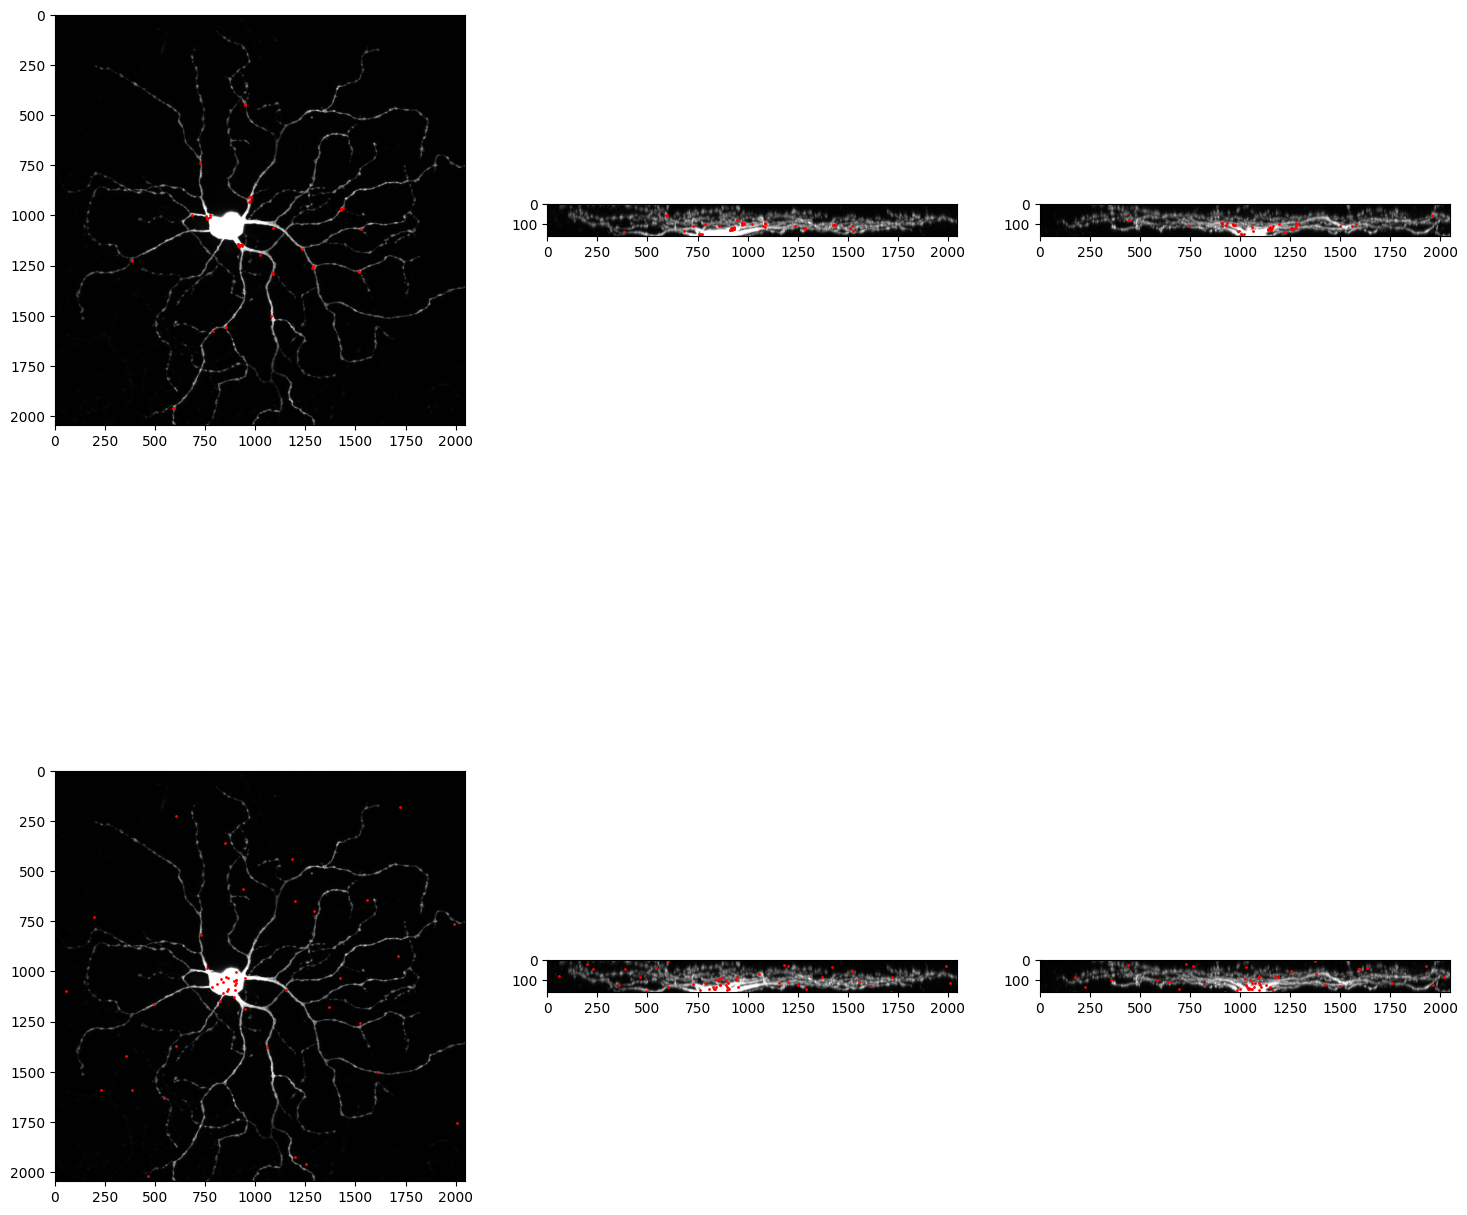

In [24]:
fig, ax = plt.subplots(2,3, figsize=(18,18))
# branch points
ax[0][0].scatter(y=points[:50,1],x=points[:50,2], c='r', s=1)
ax[0][0].imshow(img.max(0), cmap='gray')
ax[0][1].scatter(y=points[:50,0],x=points[:50,2], c='r', s=1)
ax[0][1].imshow(img.max(1), cmap='gray')
ax[0][2].scatter(y=points[:50,0],x=points[:50,1], c='r', s=1)
ax[0][2].imshow(img.max(2), cmap='gray')
# non-branch points
ax[1][0].scatter(y=points[50:,1],x=points[50:,2], c='r', s=1)
ax[1][0].imshow(img.max(0), cmap='gray')
ax[1][1].scatter(y=points[50:,0],x=points[50:,2], c='r', s=1)
ax[1][1].imshow(img.max(1), cmap='gray')
ax[1][2].scatter(y=points[50:,0],x=points[50:,1], c='r', s=1)
ax[1][2].imshow(img.max(2), cmap='gray')


## save square patches

In [29]:
img_dir = "/nafs/dtward/bryson/gold166_tifs_scaled/"
out_dir = os.path.expanduser("~/bmap/gold166_classifier_data/")
sample_points = np.load(os.path.join("/nafs/dtward/bryson/gold166_classifier_data/sample_points_03-26-25.npy"), allow_pickle=True)
sample_points = sample_points.item()

collect.save_square_patches(sample_points, img_dir, out_dir, radius=15)

  0%|          | 0/132 [00:00<?, ?it/s]

100%|██████████| 132/132 [09:54<00:00,  4.51s/it] 


## save spherical patches

In [30]:
out_dir = "/home/bgray/data/gold166_classifier_data"
sample_points = np.load("/nafs/dtward/bryson/gold166_classifier_data/sample_points_03-26-25.npy", allow_pickle=True)
sample_points = sample_points.item()
radii = torch.arange(3,34,6)
collect.save_spherical_patches(sample_points, img_dir, out_dir, radii)

100%|██████████| 132/132 [53:59<00:00, 24.54s/it] 


### View some example input images

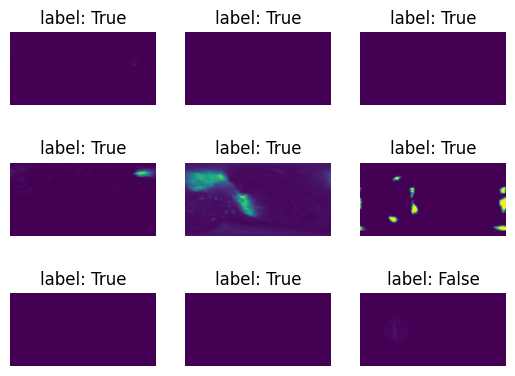

In [78]:
# observations = os.listdir(os.path.join(out_dir, "observations"))
# training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
# ids = np.random.choice(len(training_annotations), size=9)
# sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = tf.imread(os.path.join(out_dir,"observations", sample.iloc[i,0]))
    # shell = 0
    # shell = 6
    shell = 30 # type: ignore
    ax[i].imshow(img[shell], vmin=0, vmax=1.0)
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [4]:
# set source data files paths
name = "neuromorpho"
date = "04-02-25"

training_labels_file = os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_labels.csv")
test_labels_file = os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_labels.csv")
img_dir = os.path.join(out_dir, f"observations")
# img_dir = os.path.join(out_dir, f"observations")

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file, img_dir=img_dir, transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file, img_dir=img_dir)

# instantiate dataloaders
batchsize=50
training_dataloader = DataLoader(training_data, batch_size=batchsize)
test_dataloader = DataLoader(test_data, batch_size=batchsize)

In [7]:
# out_dir = os.path.expanduser("~/bmap/gold166_classifier_data/")
weights_out = os.path.join(out_dir, "classifier_weights/")
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-4
epochs = 1
# classifier = models.ResNet2D(models.ResidualBlock2D, [3, 4, 6, 3], in_channels=54, num_classes=1)
classifier = models.ResNet3D(models.ResidualBlock3D, [3, 4, 6, 3], in_channels=3, num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir=weights_out, lr=lr, epochs=epochs, classifier=classifier, state_dict=None)

### Save sample patches and labels from image files

In [ ]:
# save sample patches from the images centered at the sample points
# image_dir = "/home/brysongray/data/simulated_neurons/neuromorpho_sub1_with_artifacts"
image_dir = "/home/brysongray/"
out_dir = "classifier_data"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
name = "neuromorpho_test"

collect.collect_data(sample_points, image_dir, out_dir, name, date)

### View some example input images

In [31]:
out_dir

'/home/bgray/bmap/data/simulated_neurons/neuromorpho_branch_classifier_with_artifacts'

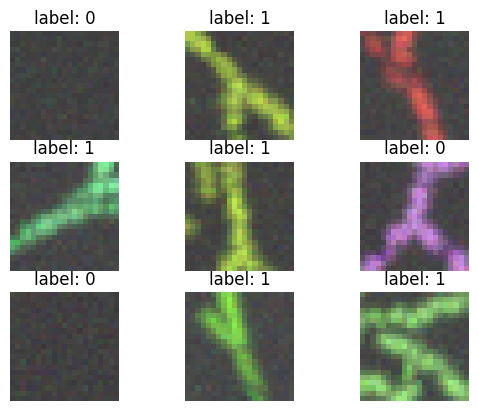

In [41]:
observations_dir = os.path.join(out_dir, "observations")
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*04-02-25_training_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img_path = os.path.join(observations_dir, sample.iloc[i,0])
    img = tf.imread(img_path) # type: ignore
    ax[i].imshow(img.transpose(1,2,3,0).max(0))#, vmax=1.0, vmin=0.0)
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

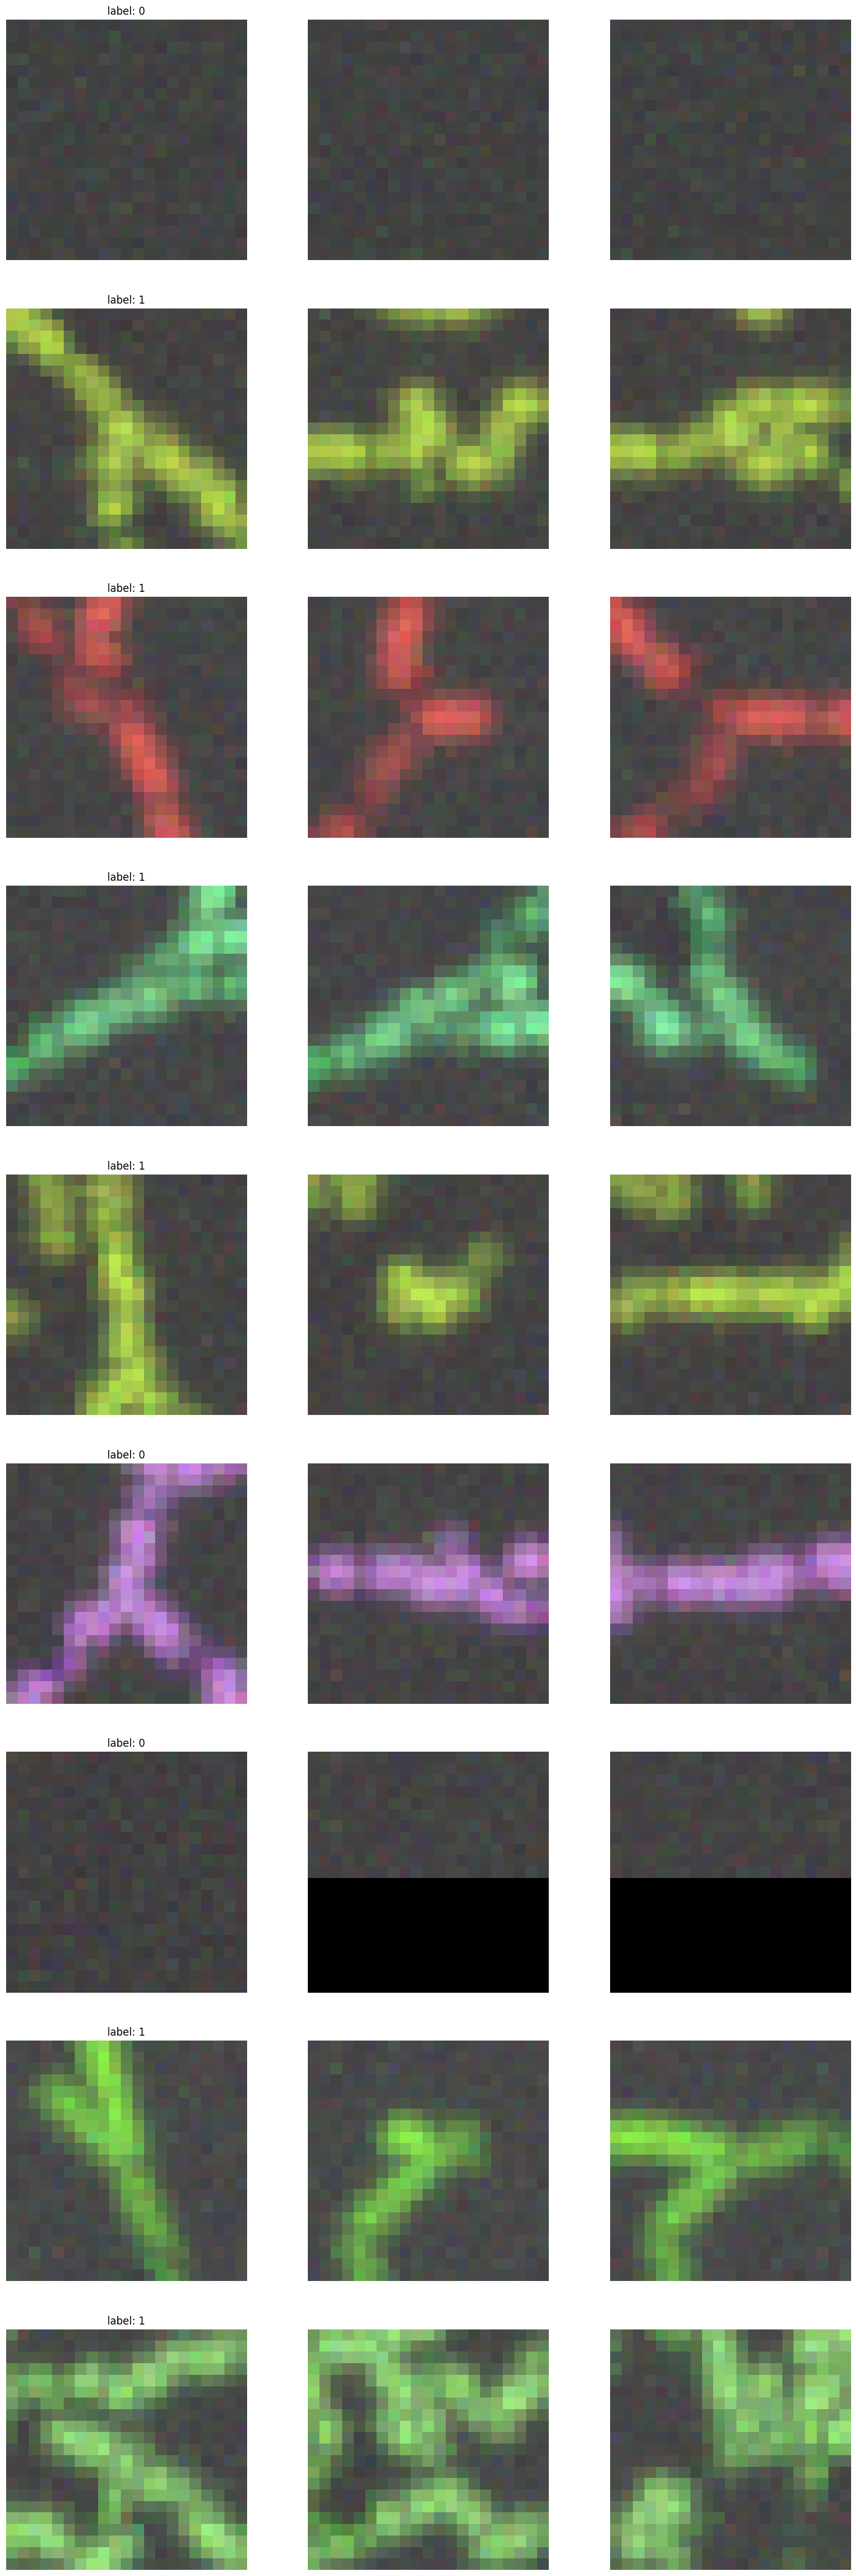

In [42]:
# look at each patch with orthogonal views
fig, ax = plt.subplots(9,3)
fig.set_size_inches(18, 54)
for i in range(len(ax)):
    img_path = os.path.join(observations_dir, sample.iloc[i,0])
    img = tf.imread(img_path)
    img = img.transpose(1,2,3,0) # type: ignore
    ax[i][0].imshow(img.max(0))#, vmax=1.0, vmin=0.0)
    ax[i][1].imshow(img.max(1))#, vmax=1.0, vmin=0.0)
    ax[i][2].imshow(img.max(2))#, vmax=1.0, vmin=0.0)
    ax[i][0].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i][0].set_axis_off()
    ax[i][1].set_axis_off()
    ax[i][2].set_axis_off()
    # ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    # ax[i].set_axis_off()

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [ ]:
# set source data files paths
training_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_test_labels.csv"
test_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_training_labels.csv"
img_dir = "classifier_data/observations"

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data)
test_dataloader = branch_classifier.init_dataloader(test_data)

## View balanced data